In [113]:
%load_ext autoreload
%autoreload 2

%reload_ext autoreload

from pathlib import Path
import sys
path = str(Path(Path('File.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import glob
import matplotlib.gridspec as gridspec
from collections import namedtuple
from analysis_tools import getobjdata

from tools.cbook import pickle2Obj, interp_z, compute_thetae
from tools.FV3_tools import read_solo_fields, read_solo_w, read_solo_w2
from tools.CM1_tools import read_cm1_fields

import copy
from metpy.plots import ctables
import matplotlib.colors as mcolors

import scipy.ndimage as ndimage

from timeit import default_timer as timer

#from Plot_tools import *
from pathlib import Path
import sys
path = str(Path(Path('File.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

from tools.plotbook import label_panels
from matplotlib.colors import LinearSegmentedColormap   

from tools.cbook import pickle2Obj

_nthreads = 10

zlevels = 10.0 + 250.*np.arange(61)

velocity_unicode = "m s\u207B\u00B9"
massflux_unicode = "kg s\u207B\u00B9"

# draw filled contours.
clevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40, 50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 750]

cmap_data = [(1.0, 1.0, 1.0),
         (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
         (0.0, 1.0, 1.0),
         (0.0, 0.8784313797950745, 0.501960813999176),
         (0.0, 0.7529411911964417, 0.0),
         (0.501960813999176, 0.8784313797950745, 0.0),
         (1.0, 1.0, 0.0),
         (1.0, 0.6274510025978088, 0.0),
         (1.0, 0.0, 0.0),
         (1.0, 0.125490203499794, 0.501960813999176),
         (0.9411764740943909, 0.250980406999588, 1.0),
         (0.501960813999176, 0.125490203499794, 1.0),
         (0.250980406999588, 0.250980406999588, 1.0),
         (0.125490203499794, 0.125490203499794, 0.501960813999176),
         (0.125490203499794, 0.125490203499794, 0.125490203499794),
         (0.501960813999176, 0.501960813999176, 0.501960813999176),
         (0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
         (0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
         (0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
         (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
         (0.4000000059604645, 0.20000000298023224, 0.0)]
cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
norm = mcolors.BoundaryNorm(clevs, cmap.N)
models = {}

# savePlots = False

# start = timer()
# cm1  = read_cm1_fields('/work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV16/S12', vars = ['w'], zinterp=zlevels, ret_ds=False)
# #solo = read_solo_fields('/work/wicker/climate_runs/FV3_Solo/squall/euler/3km/QV16/S12', vars = ['w'], zinterp=zlevels, ret_ds=False)

# end = timer()

# print(f"Time to read file: {end - start:.2f} sec")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
------------------------------------------------------------------------------------------------------------------------

 Now reading... /work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV16/S12/cm1out.nc

 Time for xarray to load:  /work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV16/S12/cm1out.nc: 12.91 sec 

 Completed setup for:  /work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV16/S12/cm1out.nc --> time to initialize variables: 1.18 sec 

 Completed reading in:  /work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV16/S12/cm1out.nc --> time to process variables: 0.02 sec 

 Interpolating fields to single column z-grid: /work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV16/S12/cm1out.nc 

 Interpolated completed, Total CPU:  /work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV16/S12: 1.49 sec 

 Total time for processing file:  /work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV16/S12: -->

In [122]:
#--------------------------------------------------------------------------------------------------------
#

def make_plot(data, label, time = 1, klevel = 18, ax_in = None, xlim=None, ylim=None, dx = 3.0, fig=None):

    if ax_in == None:
        fig, ax = plt.subplots(1,1, constrained_layout=True, figsize=(7,7))
    else:
        ax = ax_in

    CREF  = data[label]['cref'][time]
    W     = data[label]['w'][time]
    # PRES = data[label]['pres'][time]
    THpert  = data[label]['pert_th'][time]
        
    # mask_cref   = np.where(DBZ.max(axis=0) > cref_thresh, True, False)
    # mask_w_3d   = np.where(PRES < 70000.0, W, np.nan)

    # mask_w_2d   = np.nanmax(mask_w_3d, axis=0)
    # mask_w_cref = (mask_w_2d > w_thresh) & mask_cref
    # f_mask      = mask_w_cref.astype(np.int8)

    precip  = data[label]['accum_prec'][time-4:time].sum(axis=0)
        
    # ctable = radar_colormap()
    # levels = [5 + 5*n for n in range(15)]

    # colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]
    colors = [(1, 1, 1) ]
    cmap_name = 'my_list'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=2)
    
    x = dx*np.arange(W.shape[1])
    y = dx*np.arange(W.shape[2])
    
    xx, yy = np.meshgrid(x,y)

    # TH_cp = np.where(THpert[0] <= -1.0, -1.0, np.nan)
    # ax.pcolor(xx, yy, TH_cp, cmap=plt.get_cmap('bone'), alpha=0.05, edgecolors="face")

    # p_mask = np.where(precip > 1.0, precip, np.nan)
    # pmax   = precip.max()
    # ptotal = precip.sum()
    
    # precip_plot = ax.contourf(xx, yy, p_mask, models['cm1']['yc'] / 1000., norm=mlab.colors.PowerNorm(gamma=0.2))

    Wmax =  W.max(axis=0)

    ax.contour(xx, yy, Wmax, levels = [5,20], colors= 'k', alpha=1.0)

    mycolors = copy.deepcopy(ctables.colortables['NWSReflectivity'])
    mycolors.insert(0,(1,1,1))
    color_map = mcolors.ListedColormap(mycolors)
    cmin = 0.0
    cmax = 85.0
    cinc = 5.0
    cntlevels = list(np.arange(cmin,cmax,5.0))
    dbz_plot  = ax.contourf(xx, yy, CREF, levels=cntlevels, cmap=color_map, alpha=0.4)

    if fig != None:
        cbar = fig.colorbar(dbz_plot, ax=ax, shrink=0.4, location='right')
        cbar.set_label('dBZ', fontsize=10)

    if xlim != None:
        ax.set_xlim(xlim[0:2])
        ax.set_xlabel(xlim[2], fontsize=14)
    if ylim != None:
        ax.set_ylim(ylim[0:2])
        ax.set_ylabel(ylim[2], fontsize=14)

    if ax_in == None:
        return W, ax
    else:
        return W, dbz_plot
        

In [230]:
#--------------------------------------------------------------------------------------------------------
#
def plot_XY_XZ_cross_section(models, label, n, ycntr=384., xlim=[50, 350,'X (km)'], ylim=[250, 600,'Y (km)'], figure=None):

    if figure == None:
        fig = plt.figure(layout="constrained", figsize=(8*len(models.keys()),10))
    else:
        fig = figure

    gs = gridspec.GridSpec(3, 3, width_ratios=[0.8, 1, 1], height_ratios=[1, 1, 0.075])

    yc    = models['cm1']['yc'] / 1000.
    zc    = zlevels/1000.
    
    levels = np.linspace(-1., 1., 21)

# Left column
    ax1 = fig.add_subplot(gs[:, 0])
    w_cm1, _ = make_plot(models, 'cm1', ax_in = ax1, time=n, xlim=xlim, ylim=ylim)
    ax1.set_title(f"CM1: Max W: {w_cm1.max():.1f} {velocity_unicode}", fontsize=12)
    ax1.annotate("", xycoords='figure fraction', xytext=(0.18,0.8), xy=(0.28, 0.8), 
                 arrowprops=dict(facecolor='black', shrink=0.3), zorder=10)

# Right column
    ax2 = fig.add_subplot(gs[:, 2])
    w_solo, cptr = make_plot(models, 'solo', ax_in = ax2, time=n, xlim=xlim, ylim=ylim, fig=fig)
    ax2.set_title(f"FV3-Solo:  Max W: {w_solo.max():.1f} {velocity_unicode}", fontsize=12)
    ax2.tick_params(labelleft=False)
    ax2.annotate("", xycoords='figure fraction', xytext=(0.61,0.15), xy=(0.51, 0.15), 
                 arrowprops=dict(facecolor='black', shrink=0.3), zorder=10)

# Center col, top
    ax3 = fig.add_subplot(gs[0, 1])
    wfld = np.mean(w_cm1[:,146:246,:], axis=1)
    wbar = ax3.contourf(yc, zc, wfld, levels=levels, cmap='RdBu_r', extend='both' )    
    ax3.contour(yc, zc, models['cm1']['dbz'][n,:,146:246,:].max(axis=1), colors=['k'], levels=[25,])
    ax3.set_title(f"CM1: Mean W: {wfld.max():.1f} {velocity_unicode}", fontsize=12)
    ax3.tick_params(labelbottom=False)


# Center col, middle
    ax4 = fig.add_subplot(gs[1, 1])
    wfld = np.mean(w_solo[:,146:246,:], axis=1)
    wbar = ax4.contourf(yc, zc, wfld, levels=levels, cmap='RdBu_r', extend='both' )
    ax4.contour(yc, zc, models['solo']['dbz'][n,:,146:246,:].max(axis=1), colors='k', levels=[25,])
    ax4.set_title(f"FV3-Solo:  Mean W: {wfld.max():.1f} {velocity_unicode}", fontsize=12)

# Center col, bottom
    ax5 = fig.add_subplot(gs[2, 1])
                          
    cbar = fig.colorbar(wbar, cax=ax5, shrink=0.9, location='bottom', use_gridspec=True)
    cbar.set_label(f'{velocity_unicode}', fontsize=8)

    
    ax3.set_xlim(xlim[0:2])
    ax4.set_xlabel(xlim[2], fontsize=10)
    ax4.set_xlim(xlim[0:2])
    ax3.set_ylim(0.0,15.0)
    ax4.set_ylim(0.0,15.0)

    ax1.set_ylabel(ylim[2], fontsize=12)
    ax3.set_ylabel('Z (km)', fontsize=10)
    ax4.set_ylabel('Z (km)', fontsize=10)

    ax1.axhline(ycntr+99., color='k', linewidth=0.75, linestyle='--')
    ax1.axhline(ycntr-99., color='k', linewidth=0.75, linestyle='--')

    ax2.axhline(ycntr+99., color='k', linewidth=0.75, linestyle='--')
    ax2.axhline(ycntr-99., color='k', linewidth=0.75, linestyle='--')

    plt.suptitle(f"Experiment: {label} at {(n+1)//4} Hours: CREF and Max Column W ({velocity_unicode})", fontsize=14)

    return fig, [ax1, ax2, ax3, ax4]

In [ ]:
#==============================================================================================================================
# QV16S18

paths = {}
paths['cm1']  = '/work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV16/S18'
paths['solo'] = '/work/wicker/climate_runs/FV3_Solo/squall/euler/3km/QV16/S18'

QV16S18 = {}

for key in paths:
    print("\n Reading: ",key)
    if key[0:3] == 'cm1':
        QV16S18[key] = ( read_cm1_fields(paths[key], vars = ['w', 'pert_th', 'accum_prec', 'dbz'], zinterp=zlevels, ret_ds=False) )
    if key[0:4] == 'solo':
        QV16S18[key] = ( read_solo_fields(paths[key], vars = ['w', 'pert_th', 'accum_prec', 'dbz'], zinterp=zlevels, ret_ds=False) )
 

<Figure size 1600x1000 with 0 Axes>

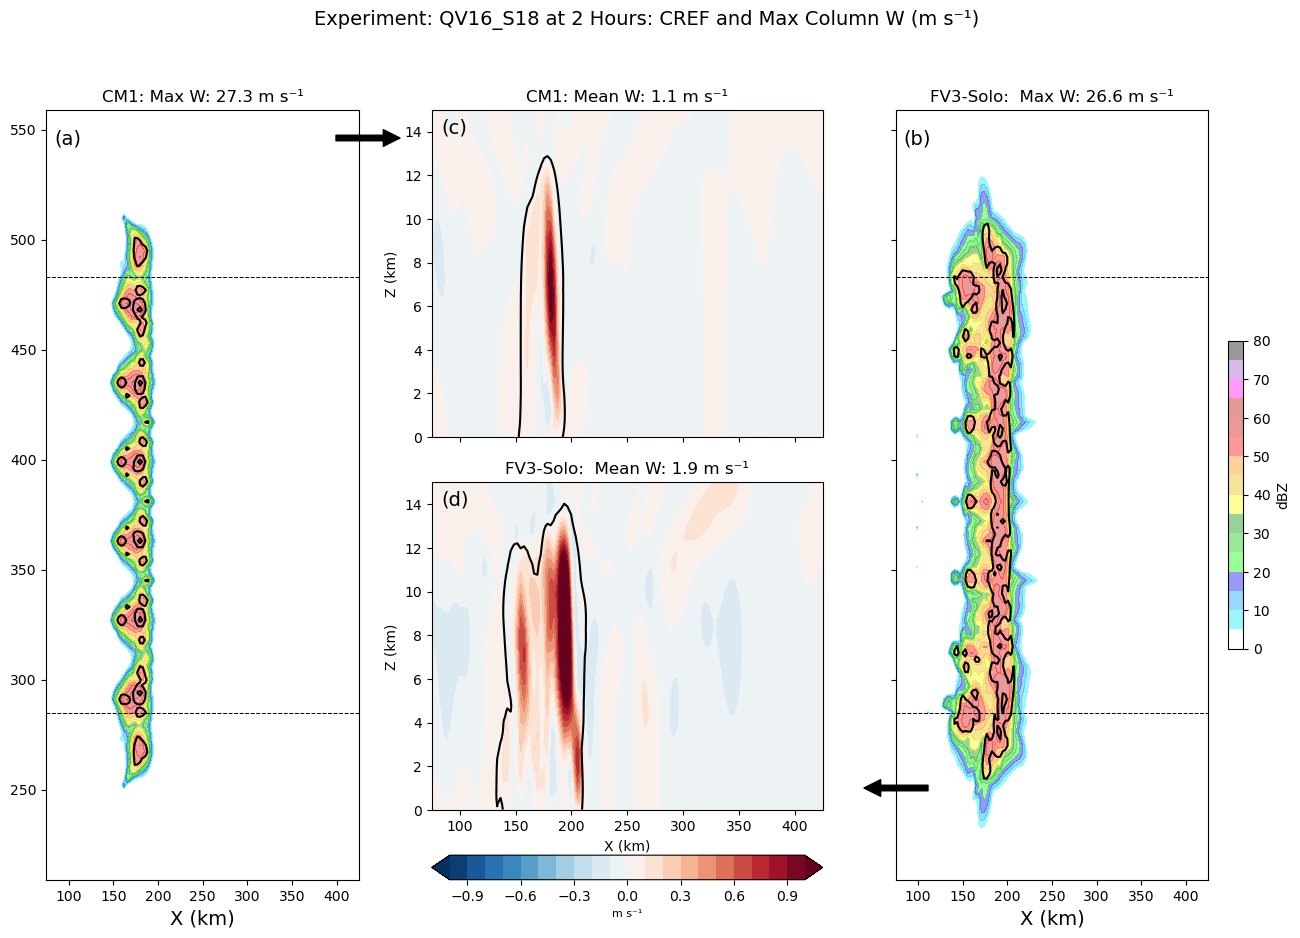

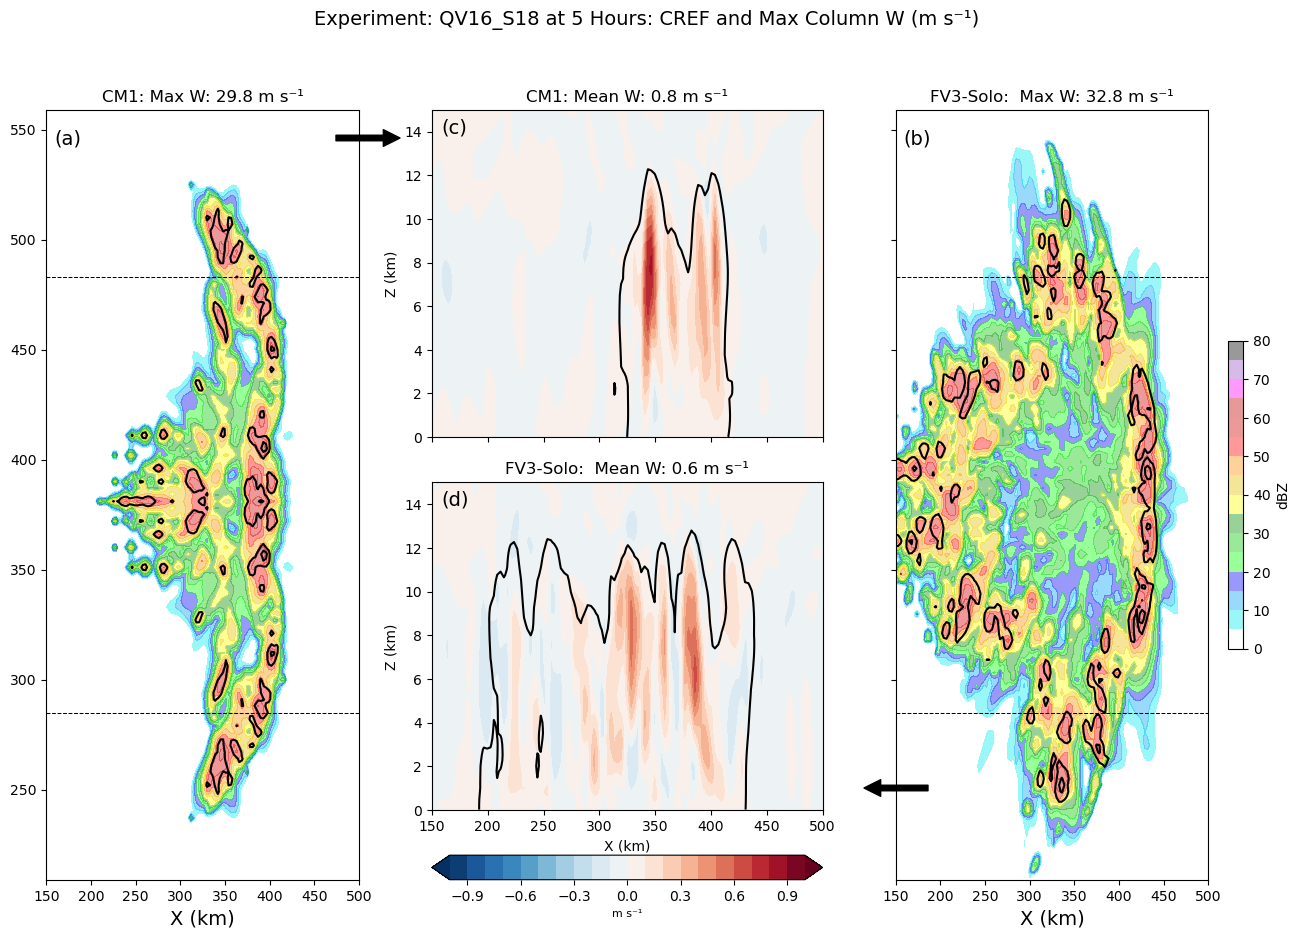

In [246]:
#==============================================================================================================================
# QV16S18

label = "QV16_S18"

fig = plt.figure(figsize=(16,10))

for n in [7, 19,]:

    match n:

        case 7: 
            ywidth = 350
            xwidth = 350
            ycntr  = 384.
            xs     = 75.

        case _: 
            ywidth = 350
            xwidth = 350
            ycntr  = 384.
            xs     = 150.

    fig, axes = plot_XY_XZ_cross_section(QV16S18, label, n, xlim=[xs, xs+xwidth, 'X (km)'], ylim=[ycntr-ywidth/2, ycntr+ywidth/2, None], figure=None);
    label_panels(axes, ('(a)', '(b)', '(c)', '(d)'))

    savefig_name = f"./Figures/SquallPlots_{label}_Hour{(n+1)//4:2d}.pdf"
    
    plt.savefig(savefig_name.replace(" ", "_"))

In [152]:
#==============================================================================================================================
# QV16S06

paths = {}
paths['cm1']  = '/work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV16/S06'
paths['solo'] = '/work/wicker/climate_runs/FV3_Solo/squall/euler/3km/QV16/S06'

QV16S06 = {}

for key in paths:
    print("\n Reading: ",key)
    if key[0:3] == 'cm1':
        QV16S06[key] = ( read_cm1_fields(paths[key], vars = ['w', 'pert_th', 'accum_prec', 'dbz'], zinterp=zlevels, ret_ds=False) )
    if key[0:4] == 'solo':
        QV16S06[key] = ( read_solo_fields(paths[key], vars = ['w', 'pert_th', 'accum_prec', 'dbz'], zinterp=zlevels, ret_ds=False) )


 Reading:  cm1
------------------------------------------------------------------------------------------------------------------------

 Now reading... /work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV16/S06/cm1out.nc

 Time for xarray to load:  /work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV16/S06/cm1out.nc: 12.77 sec 

 Reading external DBZ file: /work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV16/S06/dbz.npz

 Completed setup for:  /work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV16/S06/cm1out.nc --> time to initialize variables: 1.27 sec 

 Completed reading in:  /work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV16/S06/cm1out.nc --> time to process variables: 0.02 sec 

 Interpolating fields to single column z-grid: /work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV16/S06/cm1out.nc 

 Interpolated completed, Total CPU:  /work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV16/S06: 0.68 sec 

 Total time for processing file:  /work/wicker/climate_runs/cm1r20.3/run/

<Figure size 1600x1000 with 0 Axes>

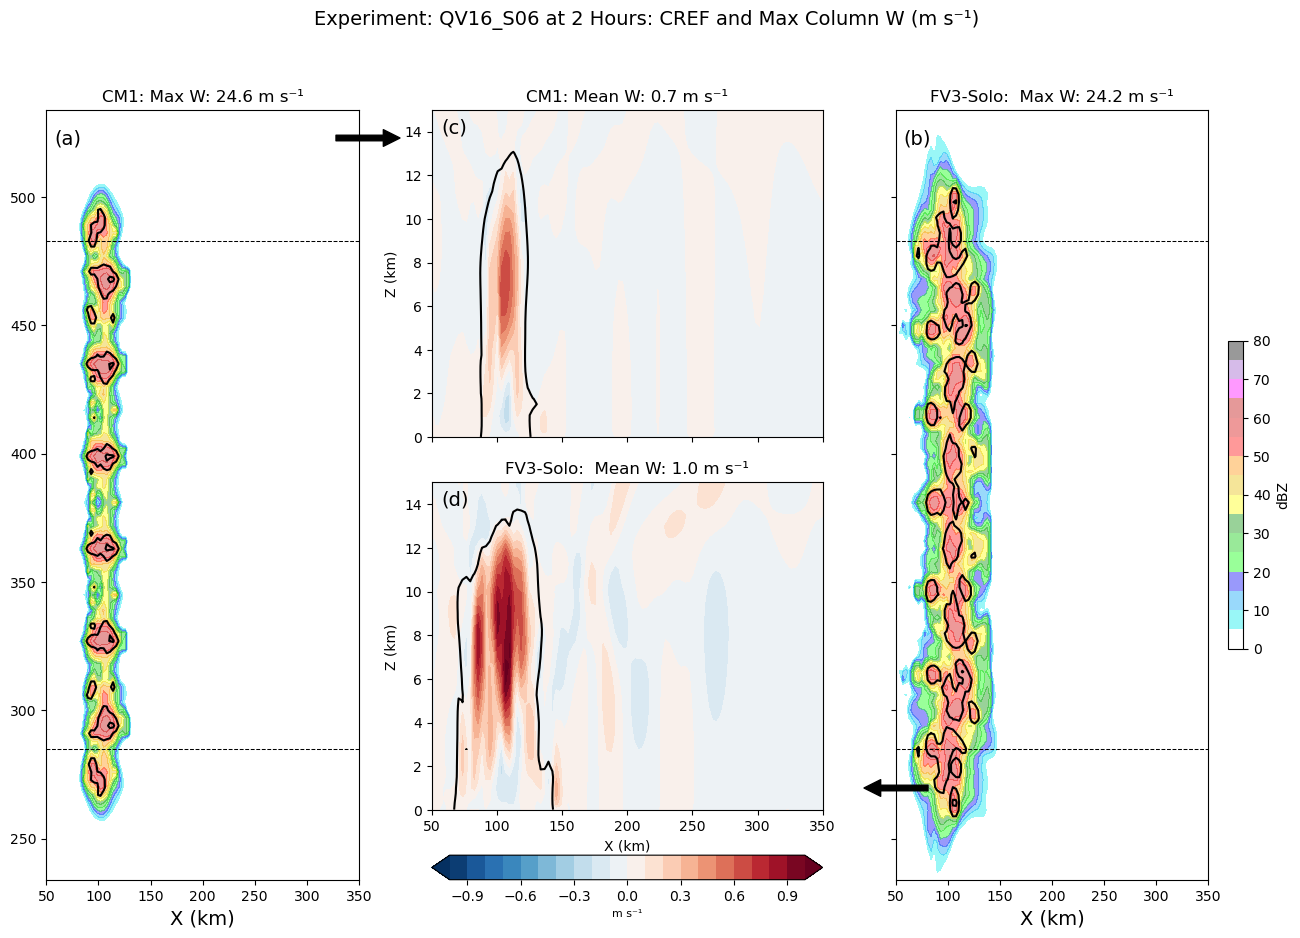

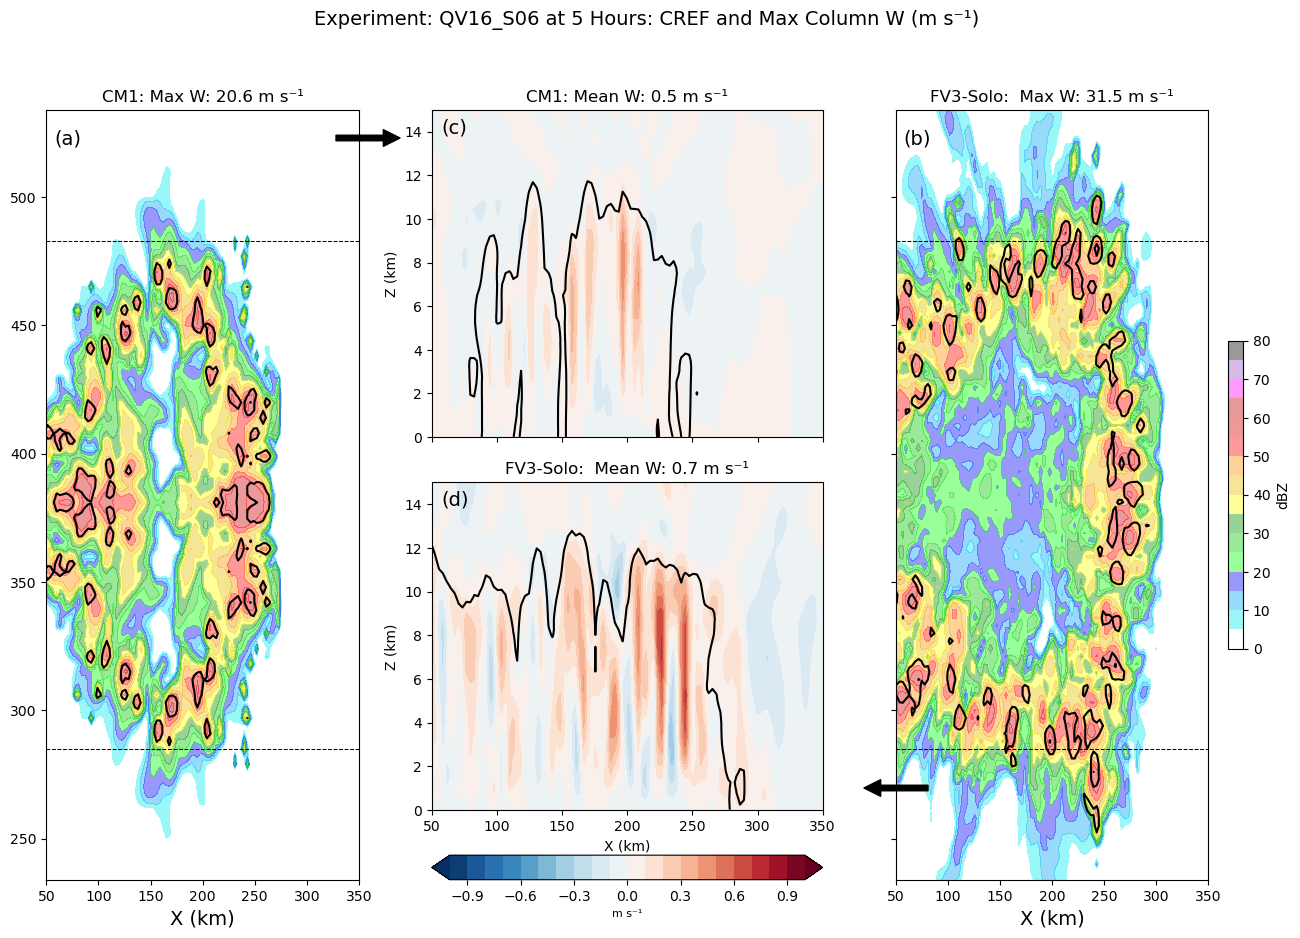

In [247]:
#==============================================================================================================================
# QV16S06
       
label = "QV16_S06"

fig = plt.figure(figsize=(16,10))

for n in [7, 19,]:

    match n:

        case 7: 
            ywidth = 300
            xwidth = 300
            ycntr  = 384.
            xs     = 50.

        case _: 
            ywidth = 300
            xwidth = 300
            ycntr  = 384.
            xs     = 50.

    fig, axes = plot_XY_XZ_cross_section(QV16S06, label, n, xlim=[xs, xs+xwidth, 'X (km)'], ylim=[ycntr-ywidth/2, ycntr+ywidth/2, None],  figure=None);
    label_panels(axes, ('(a)', '(b)', '(c)', '(d)'))
    
    savefig_name = f"./Figures/SquallPlots_{label}_Hour{(n+1)//4:2d}.pdf"
    
    plt.savefig(savefig_name.replace(" ", "_"))

In [160]:
#==============================================================================================================================
# QV13S06
paths = {}
paths['cm1']  = '/work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV13/S06'
paths['solo'] = '/work/wicker/climate_runs/FV3_Solo/squall/euler/3km/QV13/S06'

QV13S06 = {}

for key in paths:
    print("\n Reading: ",key)
    if key[0:3] == 'cm1':
        QV13S06[key] = ( read_cm1_fields(paths[key], vars = ['w', 'pert_th', 'accum_prec', 'dbz'], zinterp=zlevels, ret_ds=False) )
    if key[0:4] == 'solo':
        QV13S06[key] = ( read_solo_fields(paths[key], vars = ['w', 'pert_th', 'accum_prec', 'dbz'], zinterp=zlevels, ret_ds=False) )


 Reading:  cm1
------------------------------------------------------------------------------------------------------------------------

 Now reading... /work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV13/S06/cm1out.nc

 Time for xarray to load:  /work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV13/S06/cm1out.nc: 12.34 sec 

 Reading external DBZ file: /work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV13/S06/dbz.npz

 Completed setup for:  /work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV13/S06/cm1out.nc --> time to initialize variables: 1.24 sec 

 Completed reading in:  /work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV13/S06/cm1out.nc --> time to process variables: 0.02 sec 

 Interpolating fields to single column z-grid: /work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV13/S06/cm1out.nc 

 Interpolated completed, Total CPU:  /work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV13/S06: 0.80 sec 

 Total time for processing file:  /work/wicker/climate_runs/cm1r20.3/run/

<Figure size 1600x1000 with 0 Axes>

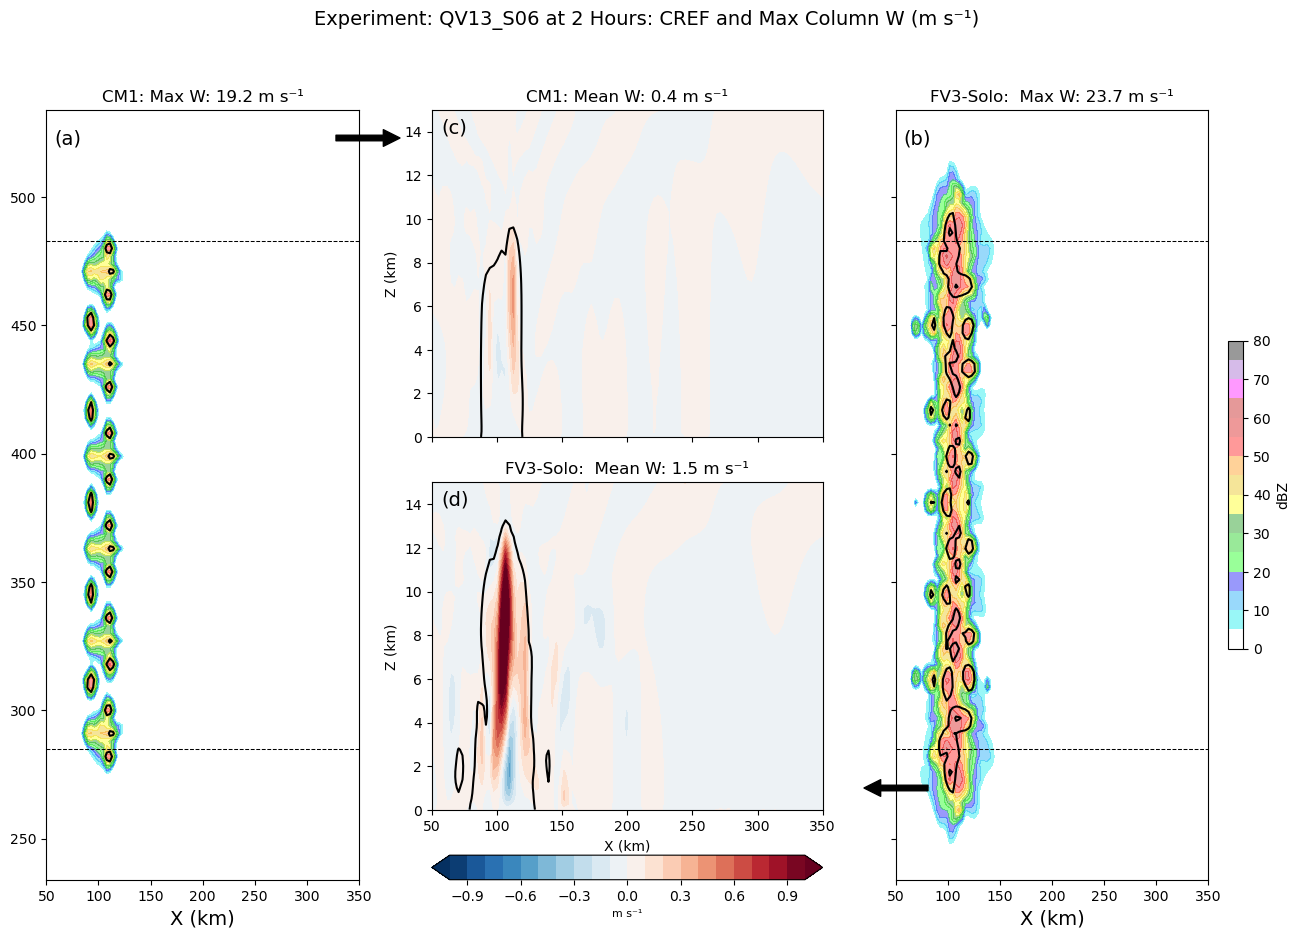

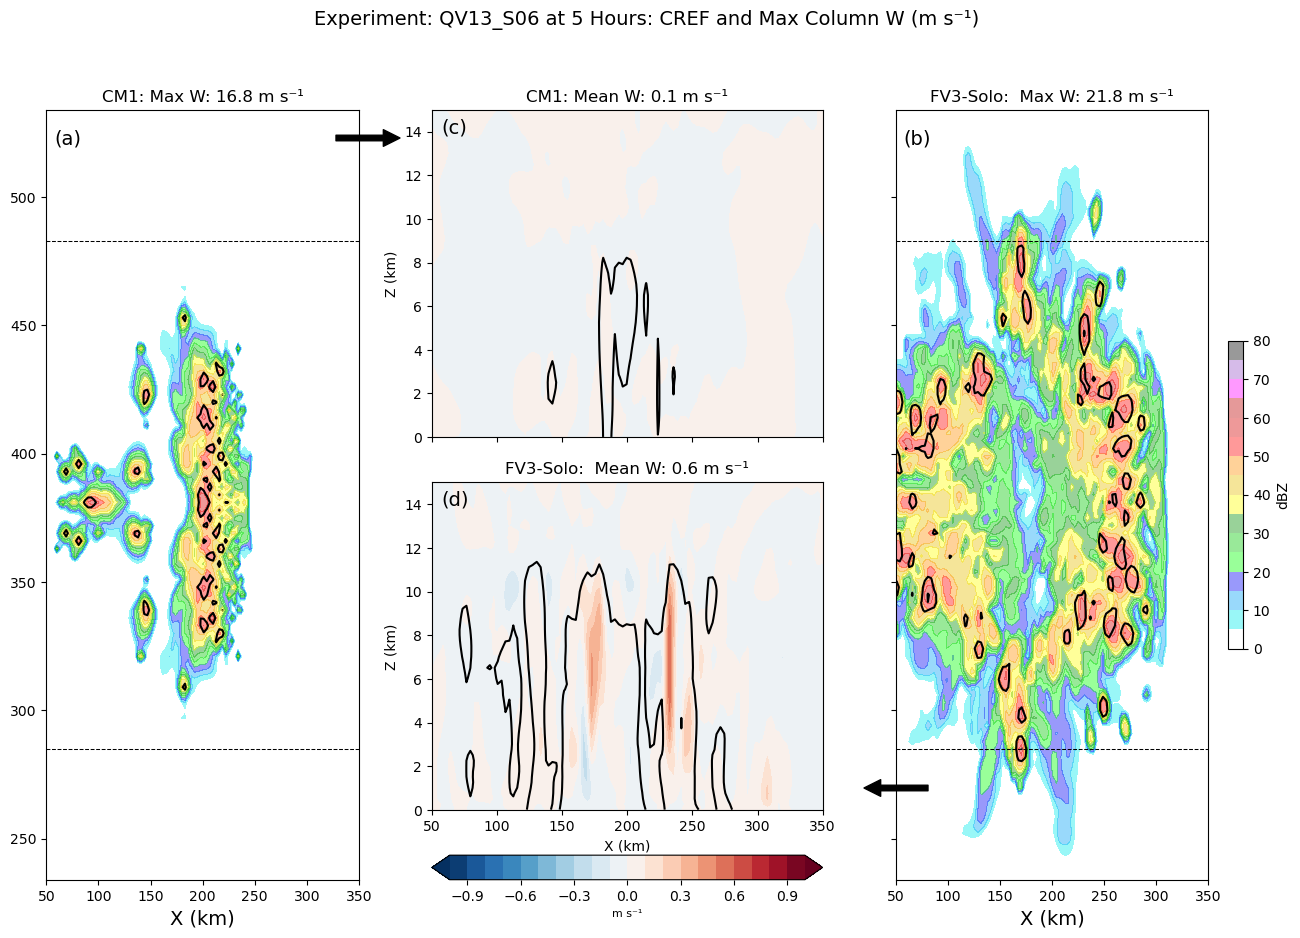

In [248]:
#==============================================================================================================================
# QV13S06

label = "QV13_S06"

fig = plt.figure(figsize=(16,10))

for n in [7, 19,]:

    match n:

        case 7: 
            ywidth = 300
            xwidth = 300
            ycntr  = 384.
            xs     = 50.

        case _: 
            ywidth = 300
            xwidth = 300
            ycntr  = 384.
            xs     = 50.    

    fig, axes = plot_XY_XZ_cross_section(QV13S06, label, n, xlim = [xs, xs+xwidth, 'X (km)'], ylim = [ycntr-ywidth/2, ycntr+ywidth/2, None], figure=None);
    label_panels(axes, ('(a)', '(b)', '(c)', '(d)'));
    
    savefig_name = f"./Figures/SquallPlots_{label}_Hour{(n+1)//4:2d}.pdf"
    
    plt.savefig(savefig_name.replace(" ", "_"))

In [162]:
paths = {}
paths['cm1']  = '/work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV13/S18'
paths['solo'] = '/work/wicker/climate_runs/FV3_Solo/squall/euler/3km/QV13/S18'

QV13S18 = {}

for key in paths:
    print("\n Reading: ",key)
    if key[0:3] == 'cm1':
        QV13S18[key] = ( read_cm1_fields(paths[key], vars = ['w', 'pert_th', 'accum_prec', 'dbz'], zinterp=zlevels, ret_ds=False) )
    if key[0:4] == 'solo':
        QV13S18[key] = ( read_solo_fields(paths[key], vars = ['w', 'pert_th', 'accum_prec', 'dbz'], zinterp=zlevels, ret_ds=False) )


 Reading:  cm1
------------------------------------------------------------------------------------------------------------------------

 Now reading... /work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV13/S18/cm1out.nc

 Time for xarray to load:  /work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV13/S18/cm1out.nc: 20.83 sec 

 Completed setup for:  /work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV13/S18/cm1out.nc --> time to initialize variables: 1.18 sec 

 Running Marshall-Palmer radar reflectivity code

 Completed reading in:  /work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV13/S18/cm1out.nc --> time to process variables: 4.56 sec 

 Interpolating fields to single column z-grid: /work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV13/S18/cm1out.nc 

 Interpolated completed, Total CPU:  /work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV13/S18: 2.07 sec 

 Total time for processing file:  /work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV13/S18: --> 28.64 sec 

---------

<Figure size 1600x1000 with 0 Axes>

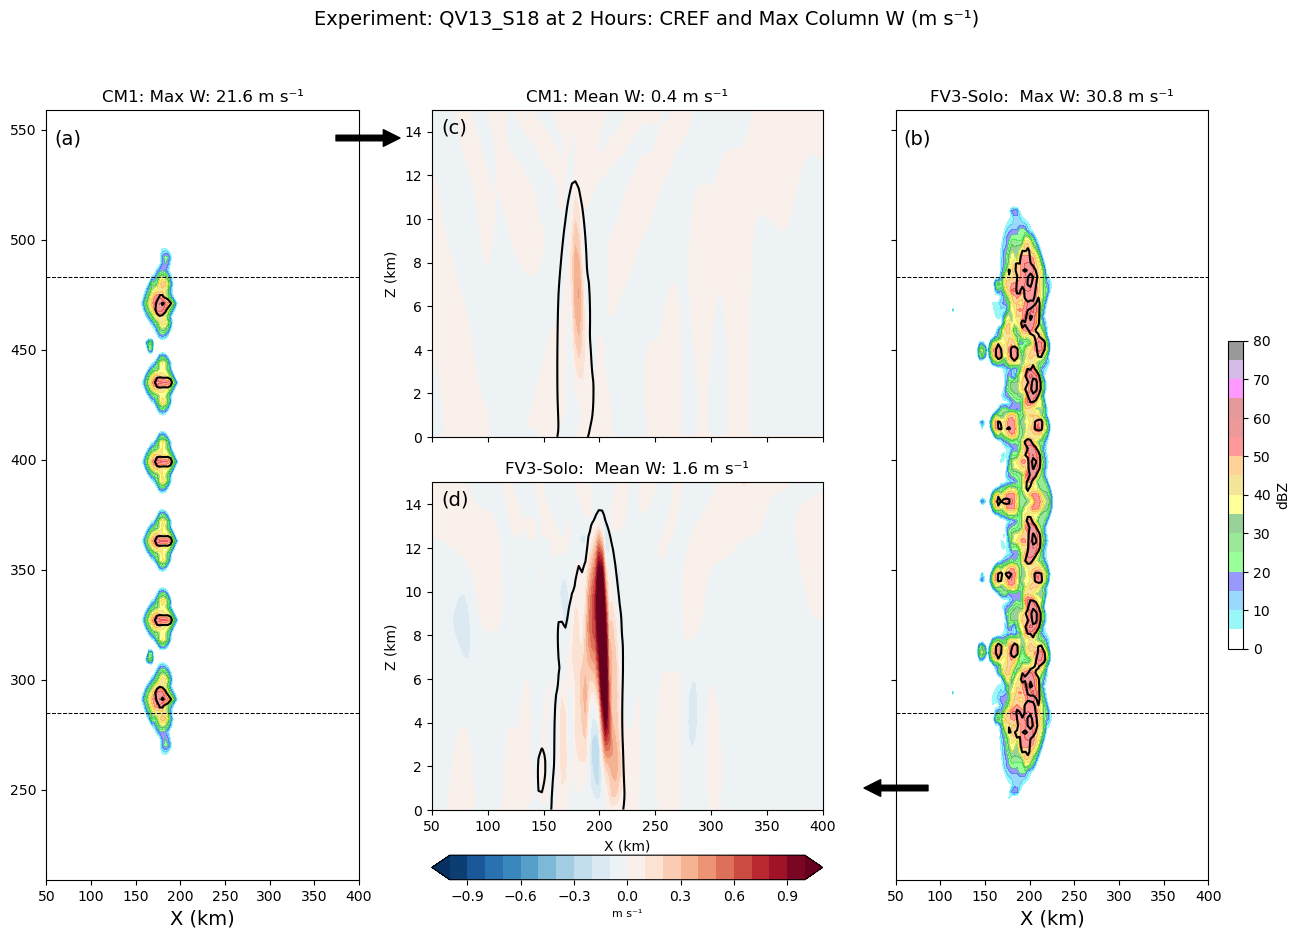

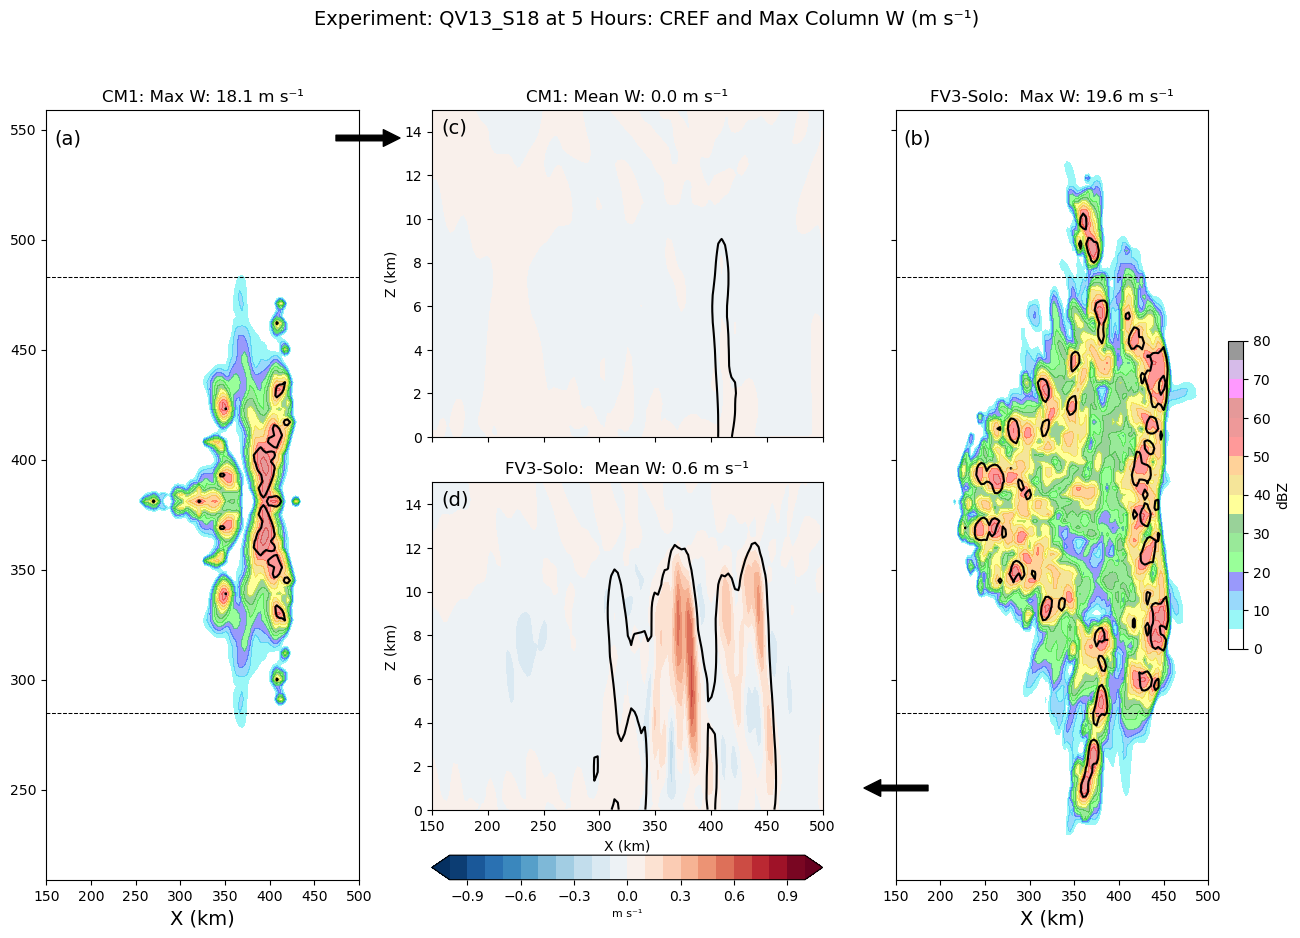

In [249]:
#==============================================================================================================================
# QV13S18

label = "QV13_S18"

fig = plt.figure(figsize=(16,10))

for n in [7, 19,]:

    match n:

        case 7: 
            ywidth = 350
            xwidth = 350
            ycntr  = 384.
            xs     = 50.

        case _: 
            ywidth = 350
            xwidth = 350
            ycntr  = 384.
            xs     = 150.

    fig, axes = plot_XY_XZ_cross_section(QV13S18, label, n, xlim = [xs, xs+xwidth, 'X (km)'], ylim = [ycntr-ywidth/2, ycntr+ywidth/2, None], figure=None);
    label_panels(axes, ('(a)', '(b)', '(c)', '(d)'));
    
    savefig_name = f"./Figures/SquallPlots_{label}_Hour{(n+1)//4:2d}.pdf"
    
    plt.savefig(savefig_name.replace(" ", "_"))